In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers import Activation
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

# Data Pre-processing

In [2]:
# Read csv
df = pd.read_csv("../compiled.csv")

# Remove 5-tuple
new_df = df.iloc[:, 5:].copy()

# Replace "inf" with numpy.nan
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns containing numpy.nan
new_df = new_df.dropna()

# Dataset Info
print(new_df.shape)
print(new_df['Label'].value_counts())
#print(df.info())
#print(df['Label'].describe())

(18697, 24)
Label
3    5611
5    5244
1    5071
2    1847
4     711
0     213
Name: count, dtype: int64


# Over Sampling (SMOTE)

In [3]:
# Separate features and labels
X = new_df.drop('Label', axis=1)
y = new_df['Label']

smote = SMOTE(sampling_strategy='auto', random_state=123)

X_res, y_res = smote.fit_resample(X, y)

# Convert resampled features and labels back to dataframes
X_res_df = pd.DataFrame(X_res, columns=X.columns)
y_res_df = pd.DataFrame(y_res, columns=['Label'])


# Normalise values
x = X_res_df
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
y = y_res_df

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

# Reshape
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_cnn= to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

y_res_df.value_counts()

(23566, 23)
(23566, 1)
(10100, 23)
(10100, 1)


Label
0        5611
1        5611
2        5611
3        5611
4        5611
5        5611
Name: count, dtype: int64

In [4]:
# Confusion matrix 
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_pred, y_test)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, label_dict.values())
    plt.yticks(tick_marks, label_dict.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# Dictionary to store results
results_dictionary = {}

# Labels Dictionary
label_dict = {
    0: "Chat",
    1: "Email",
    2: "File Transfer",
    3: "Streaming",
    4: "VoIP",
    5: "Gaming"
}

# Model Training

In [5]:
# Create the CNN Model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv1D(filters=256, input_shape=(X_train.shape[1], 1), kernel_size=1, strides=1, activation = 'relu'))
model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv1D(filters=256, kernel_size=1, strides=1, activation = 'relu'))
model.add(Dropout(0.25))

# Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(y_test_cnn.shape[1], activation='softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

model.fit(X_train_cnn, y_train_cnn, epochs = 100, validation_data = (X_test_cnn, y_test_cnn))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 256)           512       
                                                                 
 dropout (Dropout)           (None, 21, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 256)           65792     
                                                                 
 dropout_1 (Dropout)         (None, 21, 256)           0         
                                                                 
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 256)               1376512   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

742/742 [==============================] - 14s 19ms/step - loss: 0.9818 - accuracy: 0.6253 - val_loss: 0.9296 - val_accuracy: 0.6470
Epoch 48/100
742/742 [==============================] - 14s 19ms/step - loss: 0.9768 - accuracy: 0.6286 - val_loss: 0.9417 - val_accuracy: 0.6449
Epoch 49/100
742/742 [==============================] - 14s 19ms/step - loss: 0.9697 - accuracy: 0.6305 - val_loss: 0.9271 - val_accuracy: 0.6457
Epoch 50/100
742/742 [==============================] - 14s 19ms/step - loss: 0.9737 - accuracy: 0.6278 - val_loss: 0.9223 - val_accuracy: 0.6504
Epoch 51/100
742/742 [==============================] - 14s 19ms/step - loss: 0.9673 - accuracy: 0.6304 - val_loss: 0.9345 - val_accuracy: 0.6453
Epoch 52/100
742/742 [==============================] - 15s 20ms/step - loss: 0.9671 - accuracy: 0.6319 - val_loss: 0.9383 - val_accuracy: 0.6499
Epoch 53/100
742/742 [==============================] - 15s 21ms/step - loss: 0.9647 - accuracy: 0.6331 - val_loss: 0.9253 - val_accuracy

In [22]:
y_pred = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred, digits=4, target_names=label_dict.values()))

# Store Results
results_dictionary["CNN"] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1919, in _run_once
      handle._run()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Wai Qun\AppData\Local\Temp\ipykernel_12164\1619109209.py", line 1, in <module>
      y_pred = model.predict(X_test_cnn)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [32,5888], In[1]: [5376,256]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_431437]

C:\Users\Wai Qun\AppData\Local\Temp\ipykernel_6072\1614211782.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


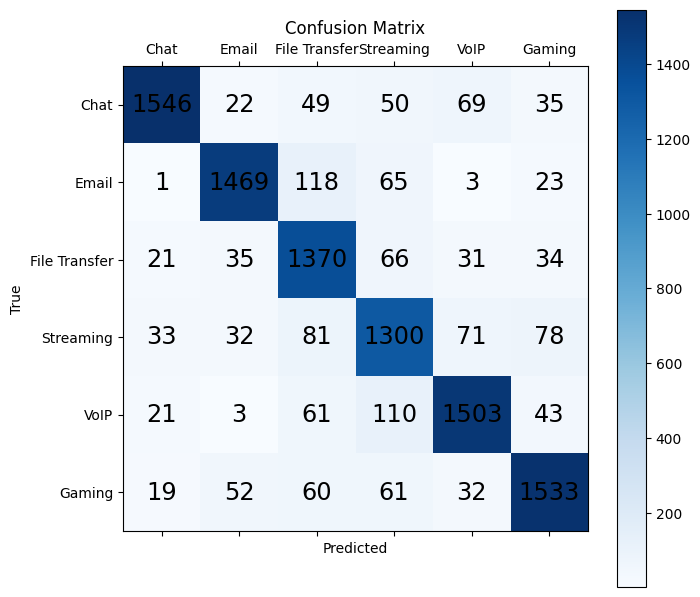

               precision    recall  f1-score   support

         Chat     0.8730    0.9421    0.9062      1641
        Email     0.8749    0.9107    0.8925      1613
File Transfer     0.8799    0.7878    0.8313      1739
    Streaming     0.8150    0.7869    0.8007      1652
         VoIP     0.8633    0.8795    0.8713      1709
       Gaming     0.8725    0.8780    0.8752      1746

     accuracy                         0.8635     10100
    macro avg     0.8631    0.8642    0.8629     10100
 weighted avg     0.8633    0.8635    0.8626     10100



In [5]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred, digits=4, target_names=label_dict.values()))

# Store Results
results_dictionary["RandomForest"] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

#Pickle model
with open('flow_RF_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
with open('encoder.pkl', 'wb') as f:
    pickle.dump(min_max_scaler, f)

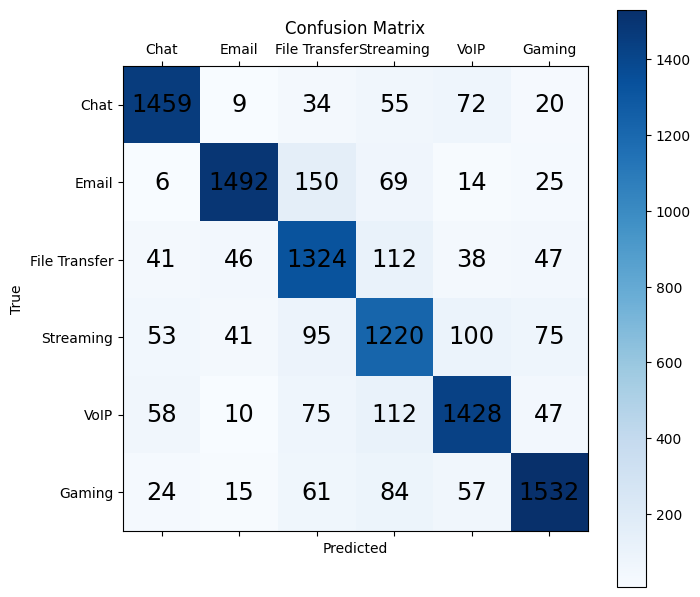

              precision    recall  f1-score   support

           0     0.8891    0.8848    0.8869      1649
           1     0.9250    0.8497    0.8857      1756
           2     0.7614    0.8234    0.7912      1608
           3     0.7385    0.7702    0.7540      1584
           4     0.8356    0.8254    0.8305      1730
           5     0.8774    0.8641    0.8707      1773

    accuracy                         0.8371     10100
   macro avg     0.8378    0.8363    0.8365     10100
weighted avg     0.8402    0.8371    0.8381     10100



In [32]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train, y_train)
y_pred = decision_tree_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["DecisionTree"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


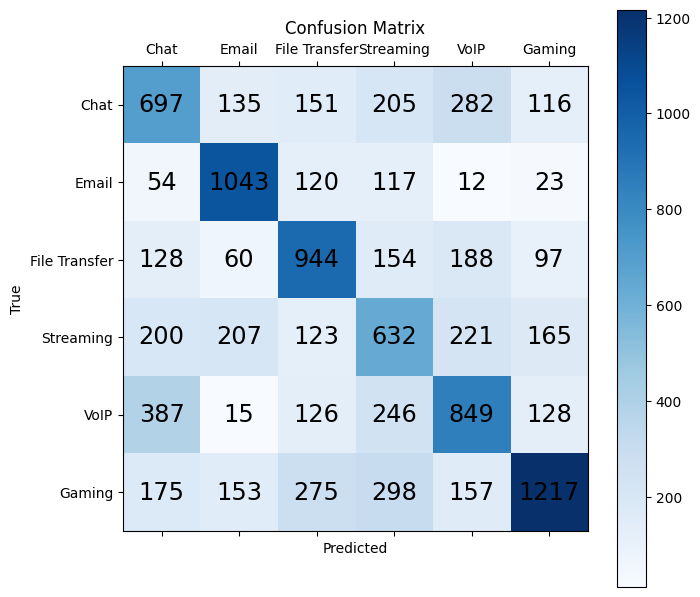

              precision    recall  f1-score   support

           0     0.4247    0.4395    0.4320      1586
           1     0.6466    0.7619    0.6995      1369
           2     0.5428    0.6009    0.5704      1571
           3     0.3826    0.4083    0.3950      1548
           4     0.4968    0.4849    0.4908      1751
           5     0.6970    0.5349    0.6053      2275

    accuracy                         0.5329     10100
   macro avg     0.5318    0.5384    0.5322     10100
weighted avg     0.5405    0.5329    0.5333     10100



In [33]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
adaboost_clf.fit(X_train, y_train)
y_pred = adaboost_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["AdaBoost"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


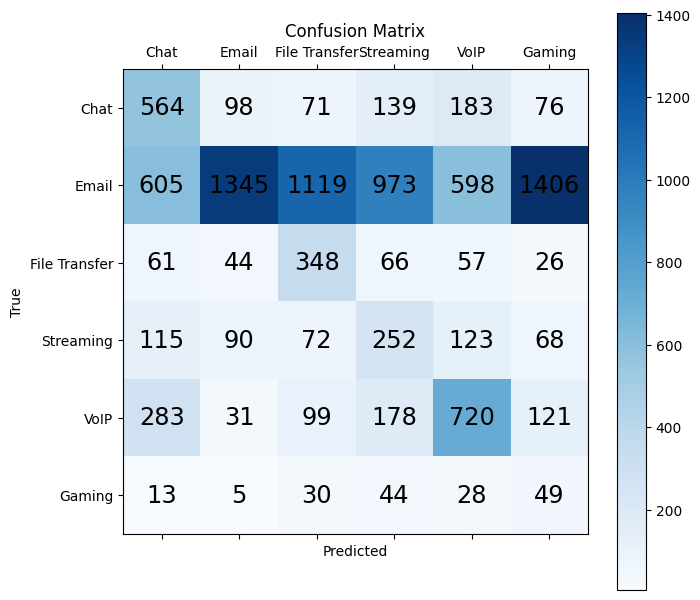

              precision    recall  f1-score   support

           0     0.3437    0.4987    0.4069      1131
           1     0.8338    0.2225    0.3512      6046
           2     0.2001    0.5781    0.2973       602
           3     0.1525    0.3500    0.2125       720
           4     0.4213    0.5028    0.4585      1432
           5     0.0281    0.2899    0.0512       169

    accuracy                         0.3246     10100
   macro avg     0.3299    0.4070    0.2963     10100
weighted avg     0.6206    0.3246    0.3545     10100



In [34]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["LogisticRegression"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


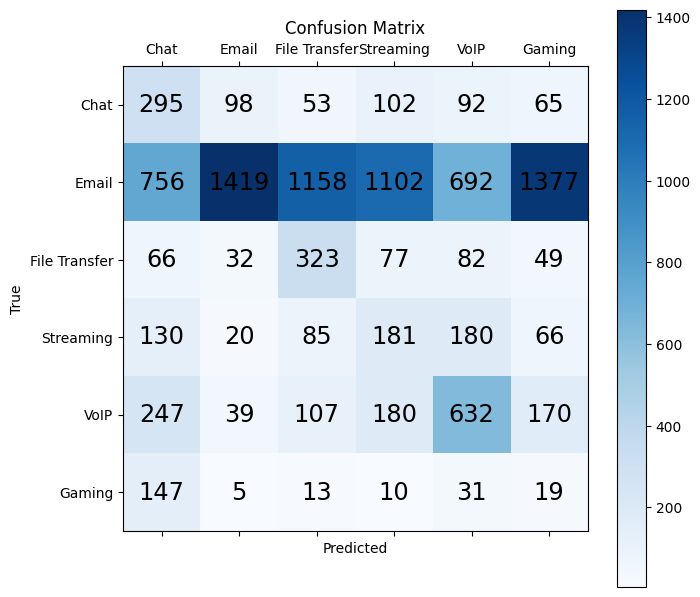

              precision    recall  f1-score   support

           0     0.1798    0.4184    0.2515       705
           1     0.8797    0.2182    0.3496      6504
           2     0.1857    0.5135    0.2728       629
           3     0.1096    0.2734    0.1564       662
           4     0.3698    0.4596    0.4099      1375
           5     0.0109    0.0844    0.0193       225

    accuracy                         0.2841     10100
   macro avg     0.2892    0.3279    0.2433     10100
weighted avg     0.6484    0.2841    0.3262     10100



In [35]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["MultinomialNB"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


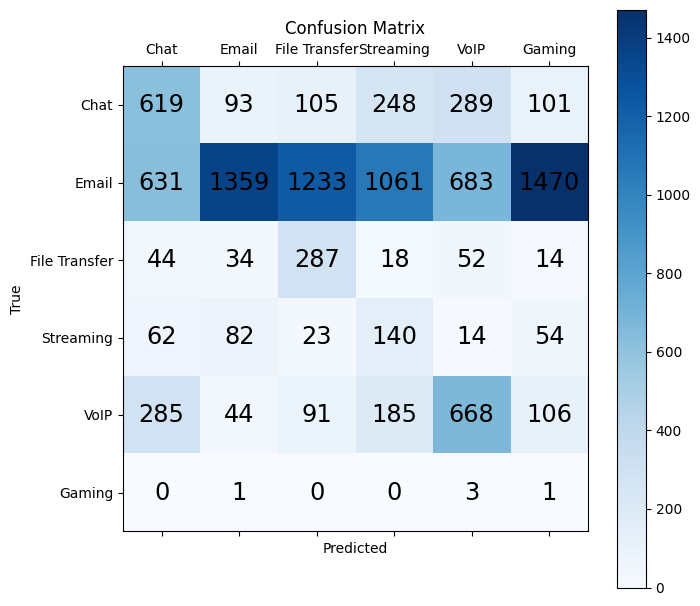

              precision    recall  f1-score   support

           0     0.3772    0.4254    0.3999      1455
           1     0.8425    0.2111    0.3376      6437
           2     0.1650    0.6392    0.2623       449
           3     0.0847    0.3733    0.1381       375
           4     0.3909    0.4844    0.4326      1379
           5     0.0006    0.2000    0.0011         5

    accuracy                         0.3044     10100
   macro avg     0.3102    0.3889    0.2620     10100
weighted avg     0.6552    0.3044    0.3487     10100



In [36]:
svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["SVM"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

In [37]:
result_df = pd.DataFrame(results_dictionary, index=['accuracy', 'precision', 'recall', 'f1'])
result_df = result_df.T
result_df

,accuracy,precision,recall,f1
RandomForest,0.864356,0.864253,0.864356,0.863479
DecisionTree,0.837129,0.836237,0.837129,0.836149
LogisticRegression,0.324554,0.408528,0.324554,0.294571
MultinomialNB,0.284059,0.328338,0.284059,0.241942
SVM,0.304356,0.390499,0.304356,0.260058
AdaBoost,0.532871,0.537834,0.532871,0.532402
